# Cifar-10 VAE

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, ELU,Dense, Lambda, InputLayer, concatenate,LeakyReLU,Conv2D,BatchNormalization,MaxPooling2D,Dropout,Flatten,Reshape,Conv2DTranspose,Activation
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.losses import mse,binary_crossentropy
from keras.utils import np_utils,plot_model


Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


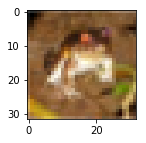

In [3]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
#print(x_train[0])
#print(y_train[0])
import matplotlib.pyplot as plt
%matplotlib inline
fig=plt.figure(figsize = (2,2))
plt.imshow(x_train[0]);


In [4]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

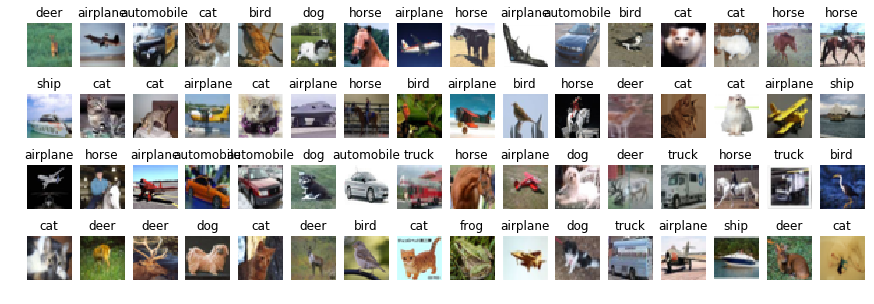

In [5]:
# show random images from train
cols = 16
rows = 4
fig = plt.figure(figsize=(1 * cols - 1, 1.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

In [5]:
#preprocess
x_train=x_train/255.
x_test=x_test/255.
y_train =keras.utils.to_categorical(y_train,10) ### YOUR CODE HERE
y_test = keras.utils.to_categorical(y_test,10)
x_train=x_train[0:1024]

First try a regular VAE. Do not condition on classes.

In [6]:
input_shape=x_train.shape[1:]
latent_dim=10
batch_size=32

In [7]:
def sampling(args):
    t_mean, t_log_var = args
    batch = K.shape(t_mean)[0]
    print(batch)
    dim = K.int_shape(t_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return t_mean + K.exp(0.5 * t_log_var) * epsilon

In [22]:
#Encoder model                                                                                                                                                                                                                                              
inputs = Input(shape=input_shape, name='encoder_input')
x=Conv2D(32,4,padding='same',kernel_initializer='he_uniform',use_bias=False)(inputs)
x=BatchNormalization()(x)
x=ELU(alpha=0.1)(x)


x=Conv2D(64,4,padding='same',kernel_initializer='he_uniform',use_bias=False,strides=2)(x)
x=BatchNormalization()(x)
x=ELU(alpha=0.1)(x)
#x=Dropout(0.2)(x)                                                                                                                                                                                                                                          

#x=MaxPooling2D((2,2))(x)                                                                                                                                                                                                                                   
#x=Dropout(0.25)(x)                                                                                                                                                                                                                                         

x=Conv2D(128,4,padding='same',kernel_initializer='he_uniform',use_bias=False,strides=2)(x)
x=BatchNormalization()(x)
x=ELU(alpha=0.1)(x)
#x=Dropout(0.25)(x)                                                                                                                                                                                                                                         

x=Conv2D(256,4,padding='same',kernel_initializer='he_uniform',use_bias=False)(x)
x=BatchNormalization()(x)
x=ELU(alpha=0.1)(x)



x=Conv2D(512,3,padding='same',kernel_initializer='he_uniform',use_bias=False,strides=2)(x)
x=BatchNormalization()(x)
x=ELU(alpha=0.1)(x)

#x=Dropout(0.25)(x)    
x=Flatten()(x)

t_mean=Dense(latent_dim,name='latentA')(x)
t_log_var=Dense(latent_dim,name='latentB')(x)

t=Lambda(sampling, output_shape=(latent_dim,), name='latent')([t_mean, t_log_var])
encoder = Model(inputs, [t_mean, t_log_var, t], name='encoder')
encoder.summary()



Tensor("latent_2/strided_slice:0", shape=(), dtype=int32)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
encoder_input (InputLayer)       (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_15 (Conv2D)               (None, 32, 32, 32)    1536        encoder_input[0][0]              
____________________________________________________________________________________________________
batch_normalization_23 (BatchNor (None, 32, 32, 32)    128         conv2d_15[0][0]                  
____________________________________________________________________________________________________
elu_14 (ELU)                     (None, 32, 32, 32)    0           batch_normalization_23[0][0]     
_________________________________

In [23]:
#Decoder                                                                                                                                                                                                                                                    
latent_inputs = Input(shape=(latent_dim,), name='t_sampling')
x = Dense(8192,kernel_initializer='he_uniform')(latent_inputs)
x=BatchNormalization()(x)
x=ELU(alpha=0.1)(x)


x=Reshape(target_shape=(4,4,512))(x)

x=Conv2DTranspose(512,3,strides=2,padding='same',kernel_initializer='he_uniform',use_bias=False)(x)
x=BatchNormalization()(x)
x=ELU(alpha=0.1)(x)



#x=Dropout(0.25)(x)                                                                                                                                                                                                                                         

x=Conv2D(256,4,padding='same',kernel_initializer='he_uniform',use_bias=False)(x)
x=BatchNormalization()(x)
x=ELU(alpha=0.1)(x)


x=Conv2DTranspose(128,4,strides=2,padding='same',kernel_initializer='he_uniform',use_bias=False)(x)
x=BatchNormalization()(x)
x=ELU(alpha=0.1)(x)
#x=Dropout(0.25)(x)                                                                                                                                                                                                                                         

x=Conv2DTranspose(64,4,padding='same',kernel_initializer='he_uniform',use_bias=False)(x)
x=BatchNormalization()(x)
x=ELU(alpha=0.1)(x)


x=Conv2DTranspose(64,4,padding='same',kernel_initializer='he_uniform',use_bias=False,strides=2)(x)
x=BatchNormalization()(x)
x=ELU(alpha=0.1)(x)
#x=Dropout(0.25)(x)                                                                                                                                                                                                                                         

outputs=Conv2D(3,4,padding='same',kernel_initializer='he_uniform',use_bias=False,activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
t_sampling (InputLayer)      (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8192)              90112     
_________________________________________________________________
batch_normalization_28 (Batc (None, 8192)              32768     
_________________________________________________________________
elu_19 (ELU)                 (None, 8192)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 8, 8, 512)         2359296   
_________________________________________________________________
batch_normalization_29 (Batc (None, 8, 8, 512)         2048      
__________

In [24]:
#Vae
mse=False
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='deepconv_vae_cifar')
reconstruction_loss = K.square(inputs-outputs) if mse else K.binary_crossentropy(inputs,outputs)
reconstruction_loss = K.mean(reconstruction_loss,axis=(1,2,3))
print(reconstruction_loss.shape)
kl_div=-0.5*K.sum(1 + t_log_var - K.square(t_mean) - K.exp(t_log_var),axis=-1) 
print(kl_div.shape)
vae_loss = K.mean(reconstruction_loss + kl_div)
vae.add_loss(vae_loss)
vae.compile(optimizer='adadelta',loss=None)
plot_model(vae,to_file='deepconv_vae_cifar.png',show_shapes=True)

Tensor("encoder_2/latent/strided_slice:0", shape=(), dtype=int32)
(?,)
(?,)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.
  if sys.path[0] == '':


In [ ]:
#train
#vae.fit(x_train,None,epochs=50,batch_size=batch_size,validation_data=(x_test, None))
#train on gpu cluster, see .py script

In [25]:
to_test=x_test[0:200]
vae.load_weights('cifar_vae3_weights500.h5')
x_test_predict=vae.predict(to_test)
print(to_test[0,0,0])
print(x_test_predict[0,0,0])

[ 0.61960784  0.43921569  0.19215686]
[ 0.4121885   0.43435547  0.4149909 ]


In [26]:
x_test_encoded=encoder.predict(to_test)
print(np.shape(x_test_encoded[0]))
print((x_test_encoded[0][0]))
print((x_test_encoded[1][0]))
print((x_test_encoded[2][0]))


(200, 10)
[ 0.13684809 -0.24509436 -0.58553696  0.7061643  -0.28284985 -0.02183104
 -1.0688349   0.95525974 -0.02106142 -0.31316423]
[-3.99187899 -3.25883412 -3.78938723 -5.18310404 -4.52348185 -4.35619307
 -4.27276134 -3.63054061 -3.14278769 -4.80499172]
[ 0.31400752 -0.28315991 -0.65897179  0.72593319 -0.4746477  -0.03631702
 -0.95678204  1.02594769 -0.4965449  -0.22649214]


In [27]:
decoded=decoder.predict(x_test_encoded[2])
print(decoded[0,0,0])

[ 0.33301088  0.35161686  0.32684338]


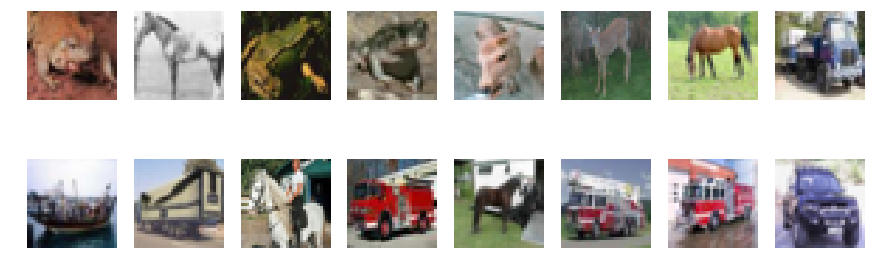

In [37]:


s=np.random.choice(range(100),size=(16))
cols = 8
rows = 2
fig = plt.figure(figsize=(2* cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        index = i*2+j
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(to_test[s[index], :])
        #ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

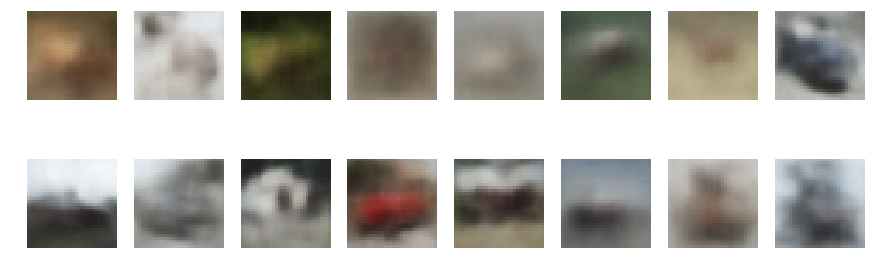

In [38]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2* cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        index = i*2+j
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(np.clip(x_test_predict[s[index], :],0.,1.))
        #ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

In [35]:
#hallucinate new images
rand_samples = np.random.normal(size=(64, latent_dim))#sample from prior
print(np.shape(rand_samples))

hallucinated_images=np.clip(decoder.predict(rand_samples),0.,1.)
#hallucinated_images=hallucinated_images*255.
print(hallucinated_images[0,0,0])

(64, 10)
[ 0.47870576  0.50342798  0.33324325]


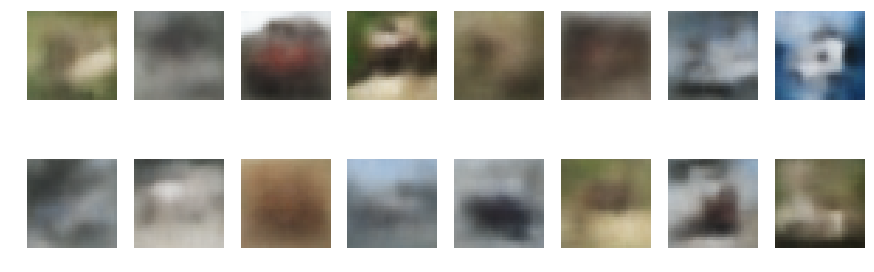

In [36]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2* cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        index = i*4+j
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(hallucinated_images[index, :])
        #ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()
